In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
currentdir = os.path.dirname(os.path.realpath('__file__'))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)
from datasets.lorenz import Lorenz96
import time

In [2]:
# Generate and plot Lorenz 63 model
tmax, dt = 6, 1e-3
num_samples = int(round(tmax/dt)) #6000
K, J = 36, 10
filename = parentdir+'/datasets/'

# Load pre-generated initial conditions
X0 = np.load(parentdir+'/datasets/L96_initial_conditions/X0.npy')
Y0 = np.load(parentdir+'/datasets/L96_initial_conditions/Y0.npy')

In [3]:
# Solve L96 system
L96 = Lorenz96(tmax, X0, Y0, num_samples)

100%|██████████| 6000/6000 [00:55<00:00, 107.88it/s]


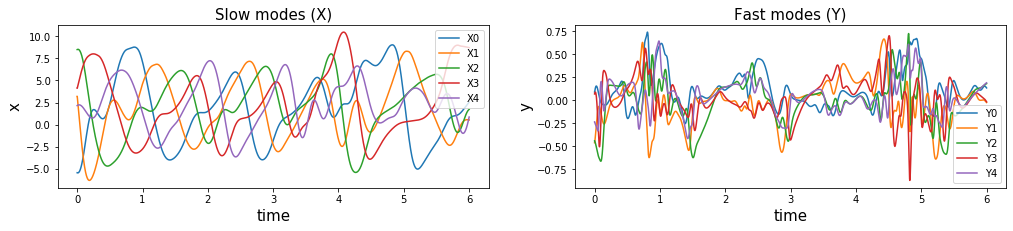

In [4]:
L96.plot()

In [5]:
h, c, b, F = L96.params
B = -1*h*c*L96.trajectory['Y'].reshape(-1,K,J).mean(-1)

## 1. Linear Regression

In [6]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [7]:
X = L96.trajectory['X']

train_X, train_B = X[:5000], B[:5000]
test_X, test_B = X[5000:], B[5000:]
#train_X, test_X, train_B, test_B = train_test_split(X, B, test_size=0.2)

Let us first assume that the subgrid term can be modelled by

$$B_k(t) = aX_k(t) + b$$

for all $k = 0, \ldots, 35$ for fixed constants $a, b$.

In [8]:
np.ravel(train_X).shape

(180000,)

In [9]:
model_lr = LinearRegression()
model_lr.fit(np.ravel(train_X)[::100, None], np.ravel(train_B)[::100, None])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [10]:
print('a = {:.4f}, b = {:.4f}'.format(model_lr.coef_[0,0], model_lr.intercept_[0]))

a = -0.2399, b = 0.0457


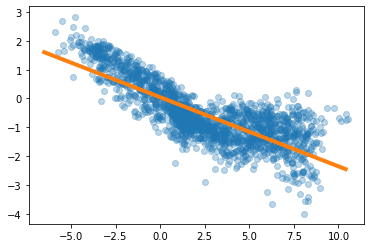

In [11]:
x = np.arange(-6.5, 10.5, 0.1)
y = model_lr.coef_[0,0] * x + model_lr.intercept_[0] # prediction

plt.scatter(np.ravel(train_X)[::100], np.ravel(train_B)[::100], alpha=0.3)
plt.plot(x, y, color='tab:orange', linewidth=4)
plt.show()

In [12]:
model_lr.score(np.ravel(test_X)[:,None], np.ravel(test_B)[:,None])

0.6563002018899424

In [13]:
def plot_subgrid(f, X, B, tmax, samplesize=4):
    """f is a function that takes an array of size (n_samples, n_features) and outputs
       an array of size (n_samples, n_features)
       X, B are arrays of size (n_samples, n_features)
    """
    Bpred = f(X)
    tspan = np.linspace(0, tmax, X.shape[0])
    fig = plt.figure(figsize=(20, 6))
    for i in range(samplesize):
        ax = plt.subplot(2, 2, i+1)
        plt.plot(tspan, Bpred[:,i], label='predicted')
        plt.plot(tspan, B[:,i], label='truth')
        ax.set_ylabel(f'B{i}', fontsize=15)
        if i == 0:
            ax.legend(fontsize=15)
        if i >= samplesize-2:
            ax.set_xlabel('time', fontsize=15)
    plt.show()

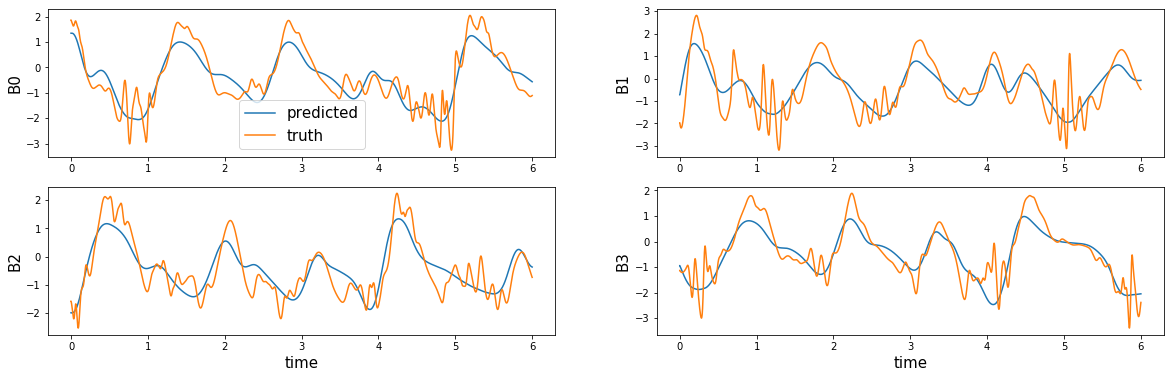

In [44]:
class reshape_args():
    def __init__(self, model):
        self.model = model
    def predict(self, X):
        batchsize, features = X.shape
        X_ravel = np.ravel(X).reshape(batchsize*features, 1)
        ypred = self.model.predict(X_ravel)
        return ypred.reshape(batchsize, features)

model_lr_modified = reshape_args(model_lr)
plot_subgrid(model_lr_modified.predict, X, B, tmax)

In [15]:
m = B[:,0][None]
for i in range(36):
    m = np.concatenate((m, X[:,i][None]), axis=0)
cov = np.corrcoef(m)

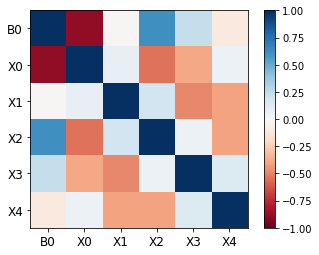

In [16]:
plt.imshow(cov[:6, :6], cmap='RdBu', vmin = -1, vmax = 1)
cb = plt.colorbar()
plt.xticks(range(6), ('B0', 'X0', 'X1', 'X2', 'X3', 'X4'), fontsize=12)
plt.yticks(range(6), ('B0', 'X0', 'X1', 'X2', 'X3', 'X4'), fontsize=12)
plt.show()

Now assume that the subgrid term takes the form

$$B_k(t) = \sum_{i=1}^K a_{k,i} X_i(t) + b_k$$

for all $k = 0, \ldots, 35$.

In [17]:
model_lr_plus = LinearRegression()
model_lr_plus.fit(train_X, train_B)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [18]:
model_lr_plus.score(test_X, test_B)

/Users/sotakao/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


-8.532902118601651

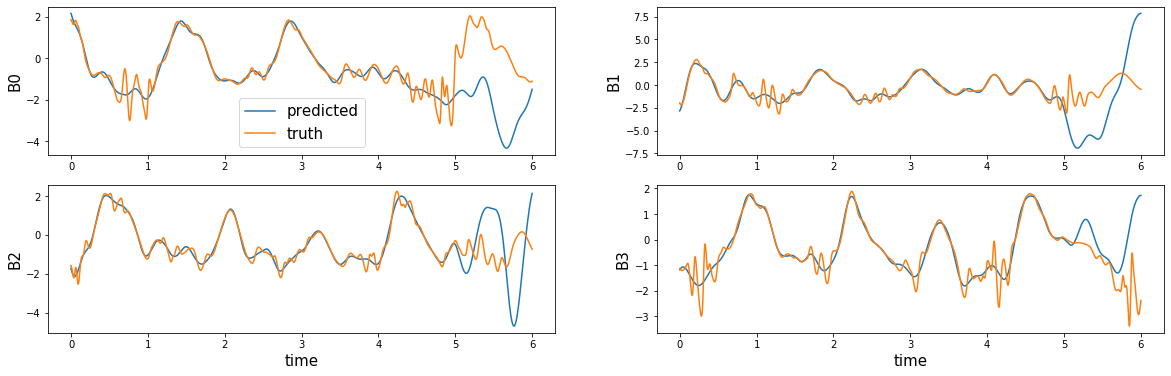

In [19]:
plot_subgrid(model_lr_plus.predict, X, B, tmax)

### Sidenote: Feature selection with Lasso

In [20]:
from sklearn.linear_model import Lasso

In [21]:
model_lasso = Lasso(alpha=0.5)

In [22]:
model_lasso.fit(train_X, train_B)
model_lasso.score(test_X, test_B)

/Users/sotakao/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.48126323150408484

In [23]:
model_lasso.coef_[0]

array([-0.21305052, -0.        ,  0.02580536,  0.        , -0.        ,
       -0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.        , -0.        ,  0.        , -0.        ,
        0.        , -0.        ,  0.        ,  0.        , -0.        ,
        0.        , -0.0042157 , -0.        , -0.        , -0.        ,
        0.        , -0.        , -0.        ,  0.01714813,  0.        ,
       -0.        , -0.        , -0.        ,  0.        , -0.        ,
       -0.        ])

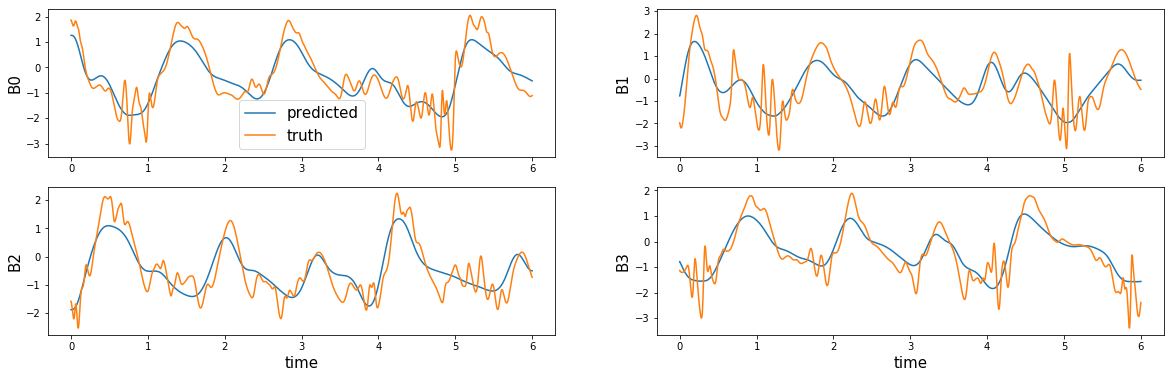

In [24]:
plot_subgrid(model_lasso.predict, X, B, tmax)

## 2. Decision Tree Regressors

In [25]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [26]:
model_dt = DecisionTreeRegressor()
model_dt.fit(train_X, train_B)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [27]:
model_dt.score(test_X, test_B)

/Users/sotakao/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


-1.2660982788796287

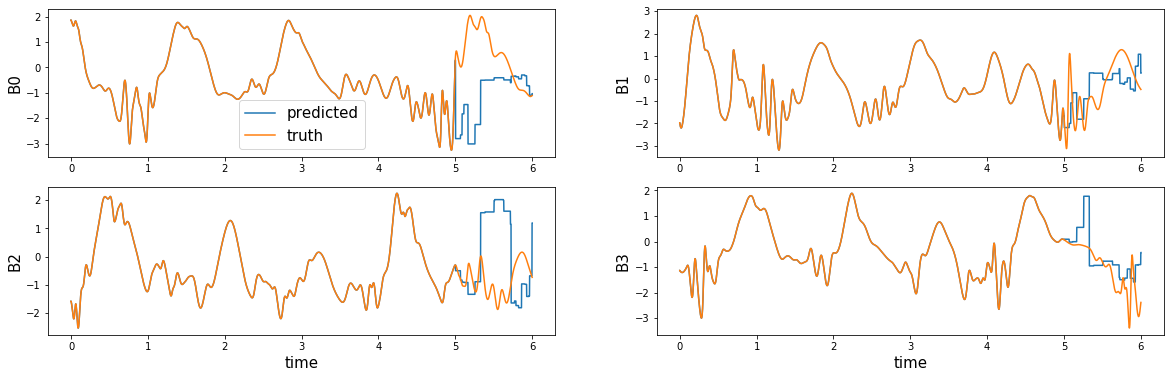

In [28]:
plot_subgrid(model_dt.predict, X, B, tmax)

### Random forest regression

In [29]:
# May take up to half a minute
model_rf = RandomForestRegressor(max_depth=10)
model_rf.fit(train_X, train_B)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [30]:
model_rf.score(test_X, test_B)

/Users/sotakao/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


-0.3707001980441238

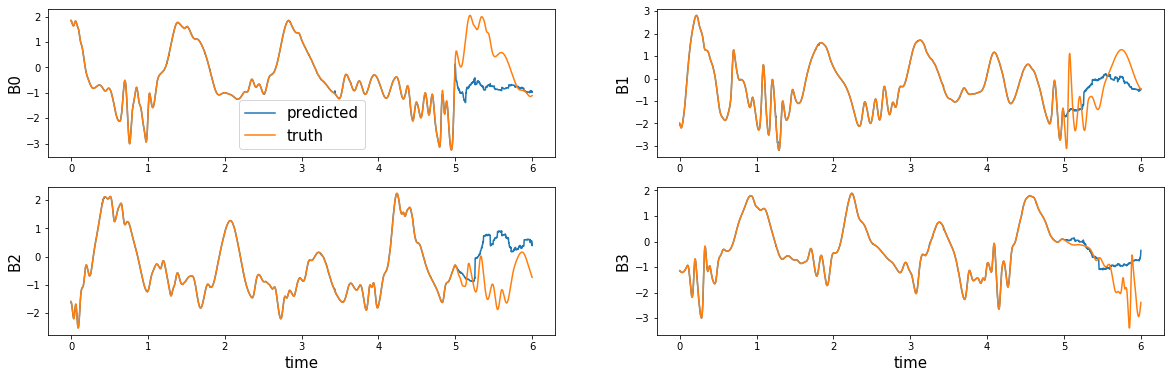

In [31]:
plot_subgrid(model_rf.predict, X, B, tmax)

In [41]:
model_rf_2 = RandomForestRegressor(max_depth=10)
model_rf_2.fit(np.ravel(train_X)[:,None], np.ravel(train_B)[:,None])
model_rf_2.score(np.ravel(test_X)[:,None], np.ravel(test_B)[:,None])

/Users/sotakao/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.7429793900531261

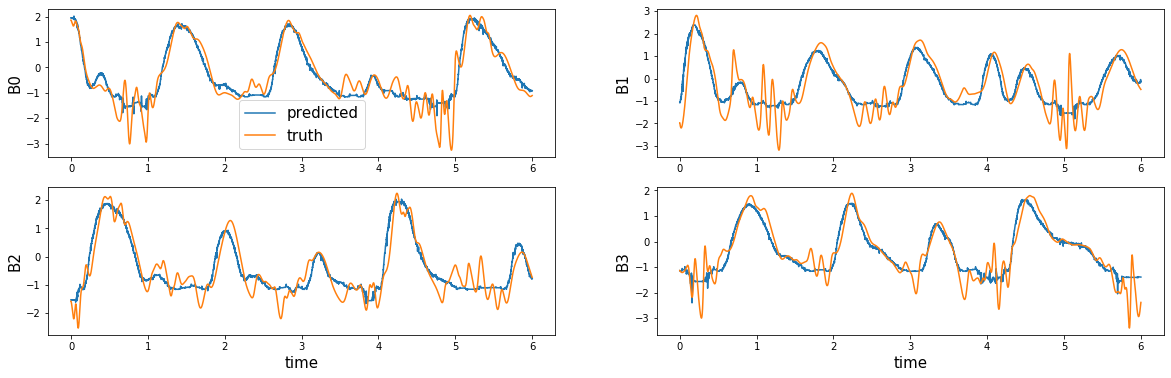

In [45]:
model_rf_2 = reshape_args(model_rf_2)
plot_subgrid(model_rf_2.predict, X, B, tmax)

## 3. Neural Networks

In [32]:
from tensorflow import keras
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers.experimental.preprocessing import Normalization

In [33]:
Normalize = Normalization()
Normalize.adapt(train_X)

In [34]:
model_nn = Sequential([
    Input(shape=(36,)),
    Normalize,
    Dense(300, activation='relu'),
    Dense(300, activation='relu'),
    Dense(300, activation='relu'),
    Dense(36)])

loss_fn = keras.losses.MeanSquaredError()
opt = keras.optimizers.Adam(learning_rate=0.001)

model_nn.compile(loss=loss_fn,
                 optimizer='adam')

model_nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 36)                73        
_________________________________________________________________
dense (Dense)                (None, 300)               11100     
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_2 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_3 (Dense)              (None, 36)                10836     
Total params: 202,609
Trainable params: 202,536
Non-trainable params: 73
_________________________________________________________________


In [35]:
model_nn.fit(train_X, train_B, epochs=20)

Epoch 1/20
157/157 [==============================] - 0s 3ms/step - loss: 0.1913
Epoch 2/20
157/157 [==============================] - 0s 3ms/step - loss: 0.0596
Epoch 3/20
157/157 [==============================] - 0s 3ms/step - loss: 0.0454
Epoch 4/20
157/157 [==============================] - 0s 3ms/step - loss: 0.0354
Epoch 5/20
157/157 [==============================] - 0s 3ms/step - loss: 0.0280
Epoch 6/20
157/157 [==============================] - 1s 4ms/step - loss: 0.0223
Epoch 7/20
157/157 [==============================] - 0s 3ms/step - loss: 0.0178
Epoch 8/20
157/157 [==============================] - 0s 3ms/step - loss: 0.0147
Epoch 9/20
157/157 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 10/20
157/157 [==============================] - 0s 3ms/step - loss: 0.0104
Epoch 11/20
157/157 [==============================] - 0s 3ms/step - loss: 0.0093
Epoch 12/20
157/157 [==============================] - 0s 3ms/step - loss: 0.0083
Epoch 13/20
157/157 [====

In [36]:
model_nn.evaluate(test_X, test_B)

32/32 [==============================] - 0s 2ms/step - loss: 1.2226


1.2226134538650513

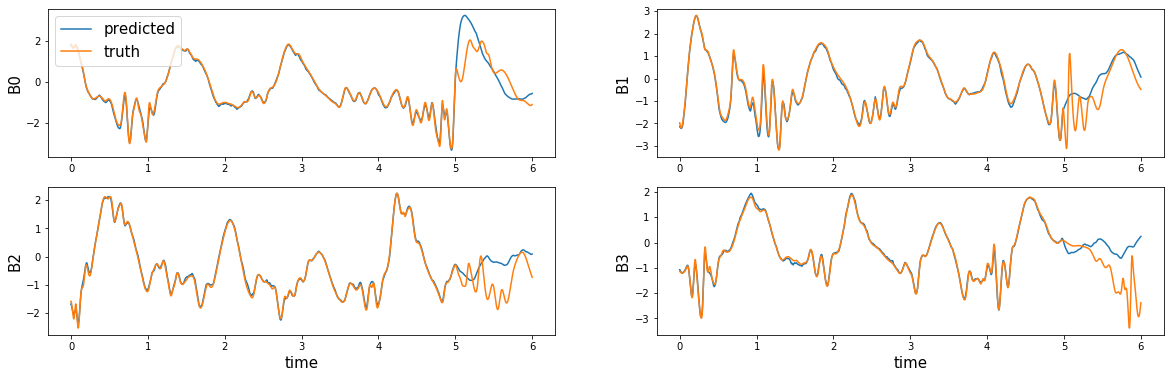

In [37]:
plot_subgrid(model_nn, X, B, tmax)

In [38]:
# To do: experiment with L1 regulariser in neural network

__Take home message:__ Sometimes simpler models work best. (maybe talk about double descent)